# Discrete Prior Class

This notebook details how to use the discrete (log) prior class within `GammaBayes` including: required inputs, attributes, and useful functionality. Once other prior classes are added to the repo they will also be detail in this notebook.

In [1]:
import sys
sys.path.append("..")
from gammabayes.prior import discrete_logprior

## Inputs

All of the inputs and the default values for the discrete (log) prior class are shown below.

1. `name='[None]'`,
2. `inputunit=None`, 
3. `logfunction=None`, 
4. `axes=None`, 
5. `axes_names='[None]'`, 
6. `hyperparameter_axes=None`, 
7. `hyperparameter_names='[None]'`,
8. `default_hyperparameter_values=None`, 
9. `logjacob=0`

The `name ` parameter is not a required parameter to instantiate the class, but details the name of the prior that you are using and can be helpful when you have multiple priors floating around.


----

The `inputunit` tells someone handling the class what are the input units. For example if you are working with energy in TeV, and sky position in galactic coordinates you might add, `inputunit='[TeV, deg, deg]'`.

___

The `logfunction` parameter is first essentially required parameter, being the function that actually outputs the log of the prior probability. Depending on what priors one is using the methods to generate this particular function is quite different and is why it is left as a general input to the class rather than having some in-built method to generate the prior from some standard input. 

The format of the inputs to function should be something like `logfunction(axis_1_val, axis_2_val, axis_3_val..., axis_n_val, hyperparameter_1_value, hyperparameter_2_value,...)` and if there are no hyperparameters then the format should just include the normalisation axes (`axis_1_val`, `axis_2_val`,...).

___

The `axes` function is also generally required, it is the range of values that the function can be evaluated at, hence the 'discrete' in the name, it can only be evaluated at the discrete values given. 

If there are multiple axes over which the prior is defined (e.g. log energy, longitude, latitude) then the input must be formatted as a tuple `(axis_1`, `axis_2`, `axis_3,)`. Unfortunately due to `Python`'s genius/stupidity, when one accesses the length of the tuple to specify the number of dimensions if there is only one axis input such as `(axis_1)` if there is no comma following the axis the length of the tuple returns the length of `axis_1`. To avoid this, if you are specifying one axis, then the format should be `(axis_1,)` and `Python` will correctly return 1 as the number of dimensions.
___

The `axes_names` input should be a tuple of strings for the names of each axis. It is not required.
___

The `hyperparameter_axes` should be a tuple containing of combinations of hyperparameters that you wish to evaluate the prior at by default, this can be over-written or blank when using methods of the class that involve the input of hyperparameters. 

e.g. If you have two hyperparameter axes `logmassrange` and `coupling_range` described as numpy arrays `np.linspace(-1,2,31)` and `np.linspace(0,1,11)` respectively the input tuple could be `(*np.meshgrid(logmassrange, couplingrange, indexing='ij),)`.

___

We then have another naming input, `hyperparameter_axes_names` which should be a tuple or list containing string representations of the names of the axes.

___

`default_hyperparameter_values` is used when constructing a prior array for a single hyperparameter value when no hyperparameter value is given. Default is `(None,)`.

___

The final possible input is `logjacob` and is the natural log of the jacobian used when integrating the prior over all it's axes. If the axes have shapes `(m_1,)`, `(m_2,)`, `(m_3,)`,..., `(m_n,)` then the logjacob argument must be of shape `(m_1, m_2, m_3,..., m_n,)`. 

e.g. You have three axes of $log_{10}$ energy, galactic longitude and galactic latitude. To normalise the prior with respect to energy one must include a jacobian $\propto log_{e}(E)$ with no jacobian needed for the other axes. The `logjacob` input should then be something like `logjacob=np.meshgrid(np.log(10**log10 energy axis), galactic longitude axis, galactic latitude axis)[0]` so that `logjacob` has the right shape.

___

## Demonstration (attributes and functionality)

Now let's do a couple demonstrations of previous uses of the discrete (log) prior class.

### Dark Matter Signal Prior

If we are looking for a dark matter gamma ray signature we need a distribution, or prior, to describe the expected signal. In `GammaBayes` this is simplified with the use of the `SS_DM_Prior` module and of course the `discrete_log_prior` class.

Starting with the `SS_DM_Prior` module, we create a function that can take in the observables of the CTA: $log_{10}$ energy (actual observable is energy), longitude and latitude. To instantiate the class we need to specify the spatial dimensions for the differential J-factors used to construct the angular distribution component of the dark matter prior. 

The way it work is that you instantiate the class with a particular dark matter mass distribution, e.g. the Einasto distribution, and then the class creates an array of the differential J-factors along the specified axes so that the factor doesn't have to be computed on every call of the output function. On calls the matrix is then simply linearly interpolated.

So we first create our axes, then instantiate the class, then use the `func_setup()` method to produce a function that can be used within the `discrete_log_prior` class.

In [2]:
import numpy as np


# We will define the log10 true energy axis at the same time
true_energy_bins_per_decade      = 100
log10_e_true_lowerbound          = np.log10(0.1)
log10_e_true_upperbound          = np.log10(100)
log10_e_true_range               = log10_e_true_upperbound-log10_e_true_lowerbound

log10_eaxis_true            = np.linspace(log10_e_true_lowerbound,log10_e_true_upperbound,int(np.round(log10_e_true_range*true_energy_bins_per_decade))+1)


# spatial axes

true_value_spatial_resolution = 0.2

## longitude axis
longitude_true_axis_lowerbound   = -3.5
longitude_true_axis_upperbound   = 3.5
longitude_true_axis_range        = longitude_true_axis_upperbound-longitude_true_axis_lowerbound

longitude_axis_true           = np.linspace(longitude_true_axis_lowerbound, 
                                            longitude_true_axis_upperbound, 
                                            int(round(longitude_true_axis_range/true_value_spatial_resolution)+1)) 

## latitude axis
latitude_true_axis_lowerbound    = -3.
latitude_true_axis_upperbound    = 3.
latitude_true_axis_range         = latitude_true_axis_upperbound-latitude_true_axis_lowerbound

latitude_axis_true            = np.linspace(latitude_true_axis_lowerbound, 
                                            latitude_true_axis_upperbound, 
                                            int(round(latitude_true_axis_range/true_value_spatial_resolution)+1)) 

The possible values of the density_profile are the same as the ones available through `Gammapy`, as the differential J-factors are calculated using that package. In this case we will use the `einasto` profile. Other options include `profiles.BurkertProfile()`, `profiles.NFWProfile()` and `profiles.IsothermalProfile()`.

In [3]:

from gammabayes.SS_DM_Prior import SS_DM_dist
from gammapy.astro.darkmatter import (
    profiles)

SS_DM_dist_instance= SS_DM_dist(longitude_axis_true, latitude_axis_true, density_profile=profiles.EinastoProfile())
logDMpriorfunc = SS_DM_dist_instance.func_setup()

/Users/lpin0002/anaconda3/envs/testywesty/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To then instantiate the class we use the input format described above for the `discrete_log_prior` class with a mass of 1 TeV

In [16]:
from gammabayes.utils.utils import makelogjacob
log10_mass_value = np.log10(1)
# The meshgrid is so that we can add the logjacob to the full matrix of prior values
logjacob_true = np.meshgrid(makelogjacob(log10_eaxis_true), longitude_axis_true, latitude_axis_true, indexing='ij')[0]

DM_prior = discrete_logprior(logfunction=logDMpriorfunc, 
                             name='Scalar Singlet Dark Matter Prior',
                             inputunit=['TeV', 'deg', 'deg'],
                             axes=(log10_eaxis_true, longitude_axis_true, latitude_axis_true,),
                             axes_names=['log10 energy', 'lon', 'lat'],
                             default_hyperparameter_values=(log10_mass_value,), # This is where the mass of 1 TeV comes in.
                             hyperparameter_names=['mass'], 
                             logjacob=logjacob_true)
DM_prior

(0.0,)


discrete log prior class
----------------------------
name = Scalar Singlet Dark Matter Prior
logfunction type is <function SS_DM_dist.func_setup.<locals>.DM_signal_dist at 0x15502ba60>
input units of ['TeV', 'deg', 'deg']
over axes ['log10 energy', 'lon', 'lat']
with hyperparameter(s) ['mass']

The two main methods that one uses this class for at the moment are: `construct_prior_array` and `sample`.

#### Sample

The `sample` method takes in the number of samples you wish for and an optional input of the matrix of log prior values, if this is left as `None` (no input) then the function will construct this for you.

The usage is very simple as most of the hard work goes into simply instantiating the prior. Here's an example usage for 10000 events.

In [5]:
dark_matter_log_e_samples, dark_matter_longitude_samples, dark_matter_latitude_samples = DM_prior.sample(int(1e4))

Let's look at the histograms for these values.

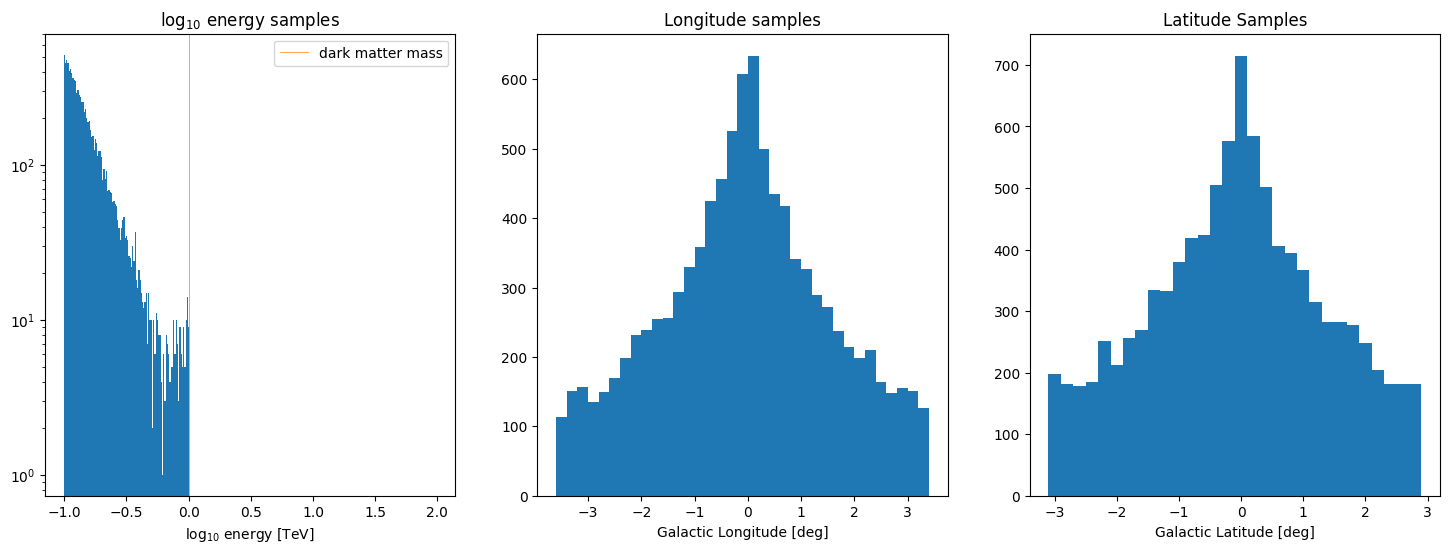

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,6))
plt.subplot(131)
plt.title(r'log$_{10}$ energy samples')
plt.hist(dark_matter_log_e_samples, bins=log10_eaxis_true-np.diff(log10_eaxis_true)[0]/2)
plt.axvline(log10_mass_value, c="tab:orange", lw=0.5, label='dark matter mass')
plt.xlabel(r'log$_{10}$ energy [TeV]')
plt.yscale('log')
plt.legend()

plt.subplot(132)
plt.title(r'Longitude samples')

plt.hist(dark_matter_longitude_samples, bins=longitude_axis_true-np.diff(longitude_axis_true)[0]/2)
plt.xlabel("Galactic Longitude [deg]")
plt.subplot(133)
plt.title(r'Latitude Samples')

plt.hist(dark_matter_latitude_samples, bins=latitude_axis_true-np.diff(latitude_axis_true)[0]/2)
plt.xlabel("Galactic Latitude [deg]")

plt.show()

One can see that there are no energy samples passed the mass of the dark matter, this is because dark matter cannot annihilate into something heavier than it started as due to the conservation of energy.

#### Construct Log Prior Matrix Values

The other primary function of the prior classes is to construct the matrix of log prior values used when doing nuisance parameter marginalisation (more detailed contained within the `hyperparameter_inference` tutorial notebook). This is done simply by calling the method `construct_prior_matrix` with the hyperparameter value of choice. E.G If we wanted the log prior values for the Z $_2$ scalar singlet dark matter model with a mass of 2 TeV we call,

In [74]:
log_dm_prior_matrix = np.squeeze(DM_prior.construct_prior_array(hyperparameters=(np.log10(2),),normalise=True))

Where the the prior is by default unnormalised and there is an extra trivial axis for the hyperparameter axis the we use np.squeeze to remove. We can then inspect the values using pcolormesh along the axes we instantiated the class with previously (together with the jacobian).

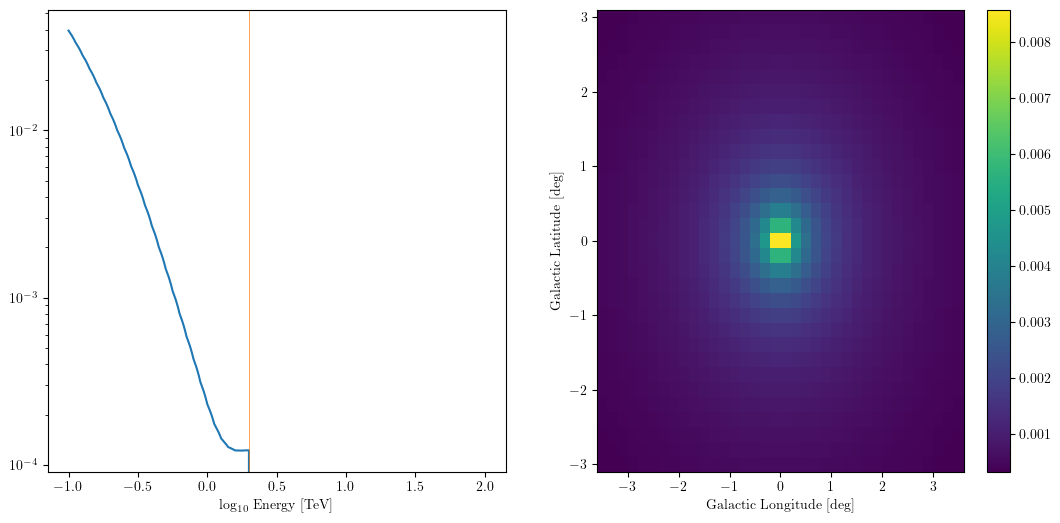

In [87]:
from scipy import special

plt.figure(figsize=(13,6))

plt.subplot(121)
plt.plot(log10_eaxis_true, np.exp(special.logsumexp(log_dm_prior_matrix+logjacob_true, axis=(1,2))))
plt.axvline(np.log10(2), c='tab:orange', lw=0.5)
plt.xlabel(r'log$_{10}$ Energy [TeV]')
plt.yscale('log')

plt.subplot(122)
plt.pcolormesh(longitude_axis_true, latitude_axis_true, np.exp(special.logsumexp(log_dm_prior_matrix+logjacob_true, axis=0).T))
plt.xlabel('Galactic Longitude [deg]')
plt.ylabel('Galactic Latitude [deg]')
plt.colorbar()
plt.show()

### Standard Model Background Priors

If we have a signal we must have a background. For this script we will consider the rates of the various components to be fixed as the analysis tutorial uses a two component mixture model. The construction of the standard model astrophysical background components please refer to the `astrophysical_background` tutorial notebook. For now we will simply use the output of that tutorial as the first of two components for the background.

In [53]:
import sys
sys.path.append("..")

from gammabayes.default_file_setup import setup


astrophysicalbackground = setup(setup_astrobkg=1, setup_irfnormalisations=0,
                                log10eaxistrue=log10_eaxis_true, longitudeaxistrue=longitude_axis_true, latitudeaxistrue=latitude_axis_true, 
                                save_results=False, outputresults=True,)

Setting up the astrophysical background


Setting up HESS sources



/Users/lpin0002/anaconda3/envs/testywesty/lib/python3.11/site-packages/gammapy/modeling/models/spatial.py:554: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)



There are 96 sources in total within the HGPS.


The other component of the background that we have to consider is the background charged cosmic ray events that are mis-identified as gamma-ray events by the CTA. This is contained within the background rate that comes with the CTA IRFs. `GammaBayes` has a wrapper for this IRF within the utils.utils module, `bkgdist`. Let's create the matrix that contains the log of this background rate in `log_misidentification_rate`.

In [54]:
from gammabayes.utils.utils import bkgdist
from scipy import special, interpolate

nuisancemesh = np.meshgrid(log10_eaxis_true, longitude_axis_true, latitude_axis_true, indexing='ij')



log_misidentification_rate = np.squeeze(bkgdist(*nuisancemesh))



Let's combine the two rates within the variable `unnormed_logbkgpriorvalues`.

In [55]:
unnormed_logbkgpriorvalues = np.logaddexp(log_misidentification_rate,np.log(astrophysicalbackground))

To use as a prior we must then normalise this rate with respect to energy, galactic longitude, and galactic latitude.

In [56]:
logbkgpriorvalues = unnormed_logbkgpriorvalues - special.logsumexp(unnormed_logbkgpriorvalues+logjacob_true)

logbkgpriorvalues.shape

(301, 36, 31)

Okay so we have the matrix of log prior values for the background, but the prior class takes in a function, so we must create an interpolation function for this matrix. We do not have to worry about normalisation as the functions within the package take care of it.

In [57]:
logbkg_matrix_interpolated = interpolate.RegularGridInterpolator((log10_eaxis_true, longitude_axis_true, latitude_axis_true,), np.exp(logbkgpriorvalues))
logbkgfunc = lambda logenergy, longitude, latitude: np.log(logbkg_matrix_interpolated((logenergy, longitude, latitude)))

Now we have everything that we need to instantiate the background prior class.

In [58]:
bkg_prior = discrete_logprior(logfunction=logbkgfunc, name='Background Prior',
                               axes=(log10_eaxis_true, longitude_axis_true, latitude_axis_true,), 
                               inputunit=['TeV', 'deg', 'deg'],
                               axes_names=['log10 energy', 'lon', 'lat'], logjacob=logjacob_true)

bkg_prior

discrete log prior class
----------------------------
name = Background Prior
logfunction type is <function <lambda> at 0x15763eac0>
input units of ['TeV', 'deg', 'deg']
over axes ['log10 energy', 'lon', 'lat']
with hyperparameter(s) [None]

We then have available the same functions as we did from the signal prior. Let's do a quick sample of the background prior and produce some "true value" samples.

In [67]:
bkg_log10_e_samples, bkg_longitude_samples, bkg_latitude_samples = bkg_prior.sample(int(round(1e6)))

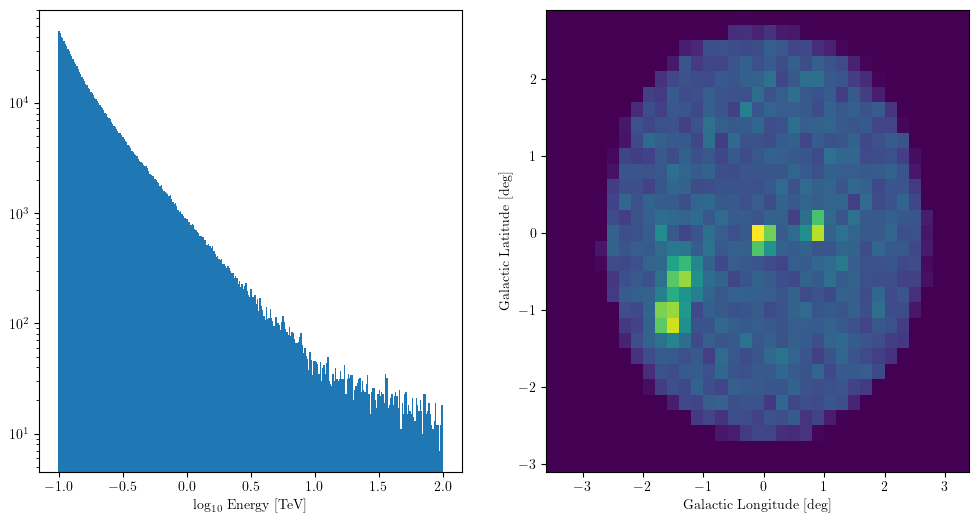

In [69]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.hist(bkg_log10_e_samples, bins=log10_eaxis_true-np.diff(log10_eaxis_true)[0]/2)
plt.yscale('log')
plt.xlabel(r'log$_{10}$ Energy [TeV]')


plt.subplot(122)
plt.hist2d(bkg_longitude_samples, bkg_latitude_samples, 
           bins=(longitude_axis_true-np.diff(longitude_axis_true)[0]/2,latitude_axis_true-np.diff(latitude_axis_true)[0]/2),
           norm=LogNorm(vmin=1e3, vmax=2e3))
plt.xlabel('Galactic Longitude [deg]')
plt.ylabel('Galactic Latitude [deg]')

plt.show()


We now recommend for one to go to the `simulations` ro `discrete (log) likelihood` tutorial notebooks.